In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import seaborn as sns  # For heatmap
import pandas as pd

def rbf_kernel(x1, x2, gamma=0.1):
    """RBF (Gaussian) kernel function."""
    return np.exp(-gamma * np.linalg.norm(x1 - x2)**2)

def generate_synthetic_data(n_samples, n_anchors, feature_dim=5, gamma=0.1):
    """Generates non-linear synthetic data using a kernel in reverse."""

    # 1. Generate Kernel Anchors (randomly)
    anchors = np.random.rand(n_anchors, feature_dim)

    # 2. Define weights and bias (randomly)
    weights = np.random.rand(n_anchors)
    bias = np.random.rand(1)[0]

    # 3. Generate Input Data Points (randomly)
    X = np.random.rand(n_samples, feature_dim)

    # 4. Calculate 'y' values (regression)
    y = np.zeros(n_samples)
    for i in range(n_samples):
        kernel_values = [rbf_kernel(X[i], anchors[j], gamma) for j in range(n_anchors)]
        y[i] = np.dot(weights, kernel_values) + bias

    return X, y

def regression_to_classification(y, num_classes=2):
    """Converts regression values to classification labels using binning."""
    if num_classes == 2:
        # Binary classification: values above 0 are class 1, below are class 0.
        y_class = (y > np.mean(y)).astype(int)  # Mean is dynamic threshold

    else:  # Multiclass classification with equal-width binning
        y_class = np.digitize(y, np.linspace(np.min(y), np.max(y), num_classes + 1)[1:-1])
    return y_class

def visualize_3d(X, y):
    """Visualizes data in 3D using PCA for dimensionality reduction."""
    pca = PCA(n_components=3)
    X_reduced = pca.fit_transform(X)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y, cmap='viridis')
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.set_zlabel("Principal Component 3")
    ax.set_title("Synthetic Data (PCA to 3D)")
    fig.colorbar(ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y, cmap='viridis'),
                 label="Class (y)", shrink=0.5, aspect=5)
    plt.show()

# Example Usage
n_samples = 1000
n_anchors = 20
X, y_regression = generate_synthetic_data(n_samples, n_anchors)  # Generate regression data

# Convert to classification
num_classes = 20 # binary classification
y_classification = regression_to_classification(y_regression, num_classes=num_classes)

# Visualize using PCA and classification labels
visualize_3d(X, y_classification)

def visualize_class_distribution(y_classification):
    """Visualizes the number of samples per class using a bar chart."""
    unique_classes, counts = np.unique(y_classification, return_counts=True)

    plt.figure(figsize=(8, 5))
    plt.bar(unique_classes, counts, color=sns.color_palette("viridis", len(unique_classes)))
    plt.xlabel("Class Label")
    plt.ylabel("Number of Samples")
    plt.title("Distribution of Samples per Class")
    plt.xticks(unique_classes) # Ensure all class labels are shown as ticks
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


visualize_class_distribution(y_classification)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from typing import List, Tuple, Dict, Optional
import matplotlib.lines as mlines # For custom legends
import matplotlib.cm # Import base colormap module

class SyntheticDatasetGenerator:
    """
    Generates synthetic federated datasets with parametric non-IID control.
    (Initialization and data generation methods remain the same as before)
    """
    def __init__(
        self,
        num_clients: int = 10,
        num_classes: int = 5,
        dim: int = 3,
        total_samples: int = 1000,
        alpha: float = 0.5,
        gamma: float = 1.0,
        beta: float = 0.1,
        delta_d: float = 0.1,
        delta_s: float = 0.0,
        class_sep: float = 2.0,
        base_cov_scale: float = 0.1,
        seed: Optional[int] = None,
    ):
        if dim < 1:
             raise ValueError("Dimension 'dim' must be at least 1.")
        if num_classes <= 1 and delta_s > 0:
            print("Warning: Concept shift (delta_s > 0) requires num_classes > 1.")
            delta_s = 0.0

        self.N = num_clients
        self.K = num_classes
        self.d = dim
        self.M = total_samples
        self.alpha = alpha
        self.gamma = gamma
        self.beta = beta
        self.delta_d = delta_d
        self.delta_s = delta_s
        self.class_sep = class_sep
        self.base_cov_scale = base_cov_scale
        self.seed = seed
        self.rng = np.random.default_rng(seed)

        self._base_means: Optional[np.ndarray] = None
        self._base_covs: Optional[List[np.ndarray]] = None
        self._client_params: Optional[Dict] = None
        # --- FIXED LINE ---
        print(f"Initialized Generator: N={self.N}, K={self.K}, d={self.d}, M={self.M}, "
              f"alpha={self.alpha:.2f}, gamma={self.gamma:.2f}, beta={self.beta:.2f}, "
              f"delta_d={self.delta_d:.2f}, delta_s={self.delta_s:.2f}")
        # --- END FIX ---

    def _initialize_base_gmm(self):
        self._base_means = np.zeros((self.K, self.d))
        self._base_covs = []
        for k in range(self.K):
            angle = 2 * np.pi * k / self.K
            self._base_means[k, 0] = self.class_sep * np.cos(angle)
            if self.d > 1: self._base_means[k, 1] = self.class_sep * np.sin(angle)
            if self.d > 2: self._base_means[k, 2] = self.class_sep * (k / self.K - 0.5)
            if self.d > 3: self._base_means[k, 3:] = self.rng.normal(0, self.class_sep * 0.1, self.d - 3)
            self._base_covs.append(np.eye(self.d) * self.base_cov_scale)
        # print("Initialized Base GMM")

    def _generate_client_parameters(self):
        if self._base_means is None: self._initialize_base_gmm()
        self._client_params = {'config': {}, 'data_indices': {}}
        client_sample_counts = np.zeros(self.N, dtype=int)
        # --- Sample count generation (robust version) ---
        if self.N == 0: # Handle case with zero clients
             if self.M > 0: print("Warning: Non-zero total samples but zero clients.")
             client_sample_counts = np.array([], dtype=int)
        elif self.gamma <= 1e-6:
             base_samples_per_client = self.M // self.N
             client_sample_counts.fill(base_samples_per_client)
             remainder = self.M % self.N
             if remainder > 0: client_sample_counts[:remainder] += 1
        else:
            log_norm_samples = self.rng.lognormal(mean=0.0, sigma=self.gamma, size=self.N)
            log_norm_samples[log_norm_samples < 1e-9] = 1e-9 # Avoid zero proportions
            proportions = log_norm_samples / log_norm_samples.sum()
            client_sample_counts = (proportions * self.M).astype(int)

            # Iterative adjustment for sum M and minimum samples
            current_sum = client_sample_counts.sum()
            required_min = 1 if self.M >= self.N else 0 # Min samples per client

            # Adjust sum first
            diff = self.M - current_sum
            if diff != 0:
                indices_to_adjust = self.rng.choice(self.N, size=abs(diff), replace=True)
                adjustment = np.sign(diff)
                np.add.at(client_sample_counts, indices_to_adjust, adjustment)
                # Ensure counts don't go below required minimum during adjustment
                client_sample_counts[client_sample_counts < required_min] = required_min

            # Ensure minimum samples (steal from max if needed)
            zero_or_neg_indices = np.where(client_sample_counts < required_min)[0]
            attempts = 0
            max_attempts = self.N * 5 # Limit attempts to prevent infinite loops

            while len(zero_or_neg_indices) > 0 and attempts < max_attempts:
                max_idx = np.argmax(client_sample_counts)
                # Only steal if max client has more than the minimum required
                if client_sample_counts[max_idx] > required_min:
                    client_sample_counts[max_idx] -= 1
                    client_sample_counts[zero_or_neg_indices[0]] += 1
                    zero_or_neg_indices = np.where(client_sample_counts < required_min)[0]
                else:
                    # Cannot steal anymore from max client
                    print(f"Warning: Could not ensure all clients have >= {required_min} samples.")
                    break
                attempts += 1

            # Final sum check after adjustments
            final_sum = client_sample_counts.sum()
            if final_sum != self.M:
                 # Fallback if adjustments failed (distribute difference randomly)
                 print(f"Warning: Sample count adjustment failed. Sum is {final_sum}. Redistributing difference.")
                 diff = self.M - final_sum
                 indices_to_adjust = self.rng.choice(self.N, size=abs(diff), replace=True)
                 adjustment = np.sign(diff)
                 np.add.at(client_sample_counts, indices_to_adjust, adjustment)
                 # Clamp again if needed
                 client_sample_counts[client_sample_counts < required_min] = required_min
                 # If sum is *still* wrong, force uniform distribution as last resort
                 if client_sample_counts.sum() != self.M:
                     print("Error: Final sample count adjustment failed. Using uniform distribution.")
                     base_samples_per_client = self.M // self.N
                     client_sample_counts.fill(base_samples_per_client)
                     remainder = self.M % self.N
                     if remainder > 0: client_sample_counts[:remainder] += 1

        # --- End Sample count generation ---
        assert client_sample_counts.sum() == self.M, f"Final sample counts sum {client_sample_counts.sum()} != {self.M}"
        assert np.all(client_sample_counts >= 0), "Negative sample counts generated"


        for i in range(self.N):
            client_id = f"client_{i}"
            params = {}
            # Ensure alpha is positive for Dirichlet
            effective_alpha = max(self.alpha, 1e-9)
            params['label_dist'] = self.rng.dirichlet(np.full(self.K, effective_alpha))
            params['feature_shift'] = self.rng.normal(0, self.beta, size=self.d)
            client_means = np.copy(self._base_means)
            client_covs = [np.copy(cov) for cov in self._base_covs]
            if self.delta_d > 0:
                for k in range(self.K):
                    mean_noise = self.rng.normal(0, self.delta_d, size=self.d)
                    client_means[k] += mean_noise
                    # Ensure covariance scale is positive and reasonably large
                    cov_scale = max(0.01, 1.0 + self.rng.normal(0, self.delta_d))
                    client_covs[k] *= cov_scale
                    # Add small diagonal noise to prevent singularity after scaling down
                    client_covs[k] += np.eye(self.d) * 1e-6
            params['means'] = client_means
            params['covs'] = client_covs
            params['num_samples'] = client_sample_counts[i]
            self._client_params['config'][client_id] = params
        # print(f"Generated parameters for {self.N} clients.")

    def generate_data(self) -> Dict[str, Tuple[np.ndarray, np.ndarray]]:
        if self._client_params is None: self._generate_client_parameters()
        client_datasets = {}
        # print("Generating data points for clients...")
        total_generated = 0
        if self.N == 0: # Handle case of zero clients
             print("Dataset generation complete. 0 clients, 0 samples.")
             return {}

        for i, client_id in enumerate(self._client_params['config']):
            params = self._client_params['config'][client_id]
            n_i = params['num_samples']
            if n_i == 0:
                client_datasets[client_id] = (np.empty((0, self.d)), np.empty((0,), dtype=int))
                continue
            client_features = np.zeros((n_i, self.d))
            client_labels_raw = np.zeros(n_i, dtype=int)
            client_labels_final = np.zeros(n_i, dtype=int)

            # Ensure label distribution sums to 1 (can have minor float issues)
            label_p = params['label_dist'] / params['label_dist'].sum()
            client_labels_raw = self.rng.choice(self.K, size=n_i, p=label_p)

            for j in range(n_i):
                label_k = client_labels_raw[j]
                mean_ik = params['means'][label_k]
                cov_ik = params['covs'][label_k]
                try:
                    # Attempt sampling
                    x_raw = self.rng.multivariate_normal(mean_ik, cov_ik)
                except np.linalg.LinAlgError:
                     # If fails, try adding jitter or using base covariance
                     # print(f"Warning: Covariance matrix issue client {i}, class {label_k}. Adding jitter.")
                     jitter = np.eye(self.d) * 1e-5
                     try:
                         x_raw = self.rng.multivariate_normal(mean_ik, cov_ik + jitter)
                     except np.linalg.LinAlgError:
                         # Last resort: use base covariance
                         # print(f"Warning: Jitter failed. Using base covariance for client {i}, class {label_k}.")
                         base_cov = self._base_covs[label_k]
                         x_raw = self.rng.multivariate_normal(mean_ik, base_cov)

                x_transformed = x_raw + params['feature_shift']
                client_features[j] = x_transformed
                y_final = label_k
                if self.delta_s > 0 and self.K > 1:
                    if self.rng.random() < self.delta_s:
                        possible_labels = list(range(self.K))
                        possible_labels.remove(label_k)
                        if possible_labels: y_final = self.rng.choice(possible_labels)
                client_labels_final[j] = y_final
            client_datasets[client_id] = (client_features, client_labels_final)
            total_generated += n_i
            # if i % max(1, self.N // 10) == 0 or i == self.N - 1:
            #      print(f"  Generated data for client {i+1}/{self.N} ({client_id}) - {n_i} samples")
        print(f"Dataset generation complete. Total samples: {total_generated}")
        return client_datasets

    def visualize_combined(
        self,
        client_datasets: Dict[str, Tuple[np.ndarray, np.ndarray]],
        max_total_samples: int = 1000,
        max_clients_to_plot: Optional[int] = None
    ):
        print(f"Generating combined visualization (d={self.d})...")

        if not client_datasets:
             print("Client datasets dictionary is empty. Cannot visualize.")
             return

        client_ids = list(client_datasets.keys())
        num_available_clients = len(client_ids)

        if max_clients_to_plot is not None and max_clients_to_plot < num_available_clients:
             clients_to_plot_ids = client_ids[:max_clients_to_plot]
             num_clients_for_cmap = max_clients_to_plot
             print(f"  Plotting subset of clients: {len(clients_to_plot_ids)}/{num_available_clients}")
        else:
             clients_to_plot_ids = client_ids
             num_clients_for_cmap = num_available_clients
             max_clients_to_plot = num_available_clients # Ensure consistency

        all_features_list = []
        all_labels_list = []
        all_client_indices_list = [] # Store index relative to clients_to_plot_ids
        client_id_map = {cid: idx for idx, cid in enumerate(clients_to_plot_ids)} # Map client_id to its plot index

        current_total_samples = 0
        actual_clients_plotted = 0

        for client_id in clients_to_plot_ids:
            if client_id not in client_datasets: continue # Should not happen with current logic, but safe check
            features, labels = client_datasets[client_id]
            n_client = features.shape[0]
            if n_client == 0: continue

            samples_to_take = min(n_client, max(0, max_total_samples - current_total_samples))
            if samples_to_take == 0 and current_total_samples >= max_total_samples:
                 continue

            if samples_to_take < n_client:
                indices = self.rng.choice(n_client, size=samples_to_take, replace=False)
                features_sub = features[indices]
                labels_sub = labels[indices]
            else:
                features_sub = features
                labels_sub = labels

            all_features_list.append(features_sub)
            all_labels_list.append(labels_sub)
            # Use the index from the subset being plotted
            all_client_indices_list.append(np.full(samples_to_take, client_id_map[client_id], dtype=int))
            current_total_samples += samples_to_take
            if samples_to_take > 0:
                 actual_clients_plotted += 1

        if not all_features_list:
            print("No data points to plot (after filtering/subsampling).")
            return

        features_agg = np.vstack(all_features_list)
        labels_agg = np.concatenate(all_labels_list)
        client_indices_agg = np.concatenate(all_client_indices_list) # Indices from 0 to num_clients_for_cmap-1

        print(f"  Aggregated {current_total_samples} samples from {actual_clients_plotted} clients for plotting.")

        # --- Define Colors and Markers ---
        try:
            # Use a perceptually uniform colormap if available and looks good
            client_cmap = matplotlib.cm.get_cmap('turbo', num_clients_for_cmap)
        except ValueError:
            # Fallback if cmap doesn't support N colors directly
            client_cmap = matplotlib.cm.get_cmap('turbo')
        client_colors = client_cmap(np.linspace(0, 1, num_clients_for_cmap))

        markers = ['o', 's', '^', 'P', '*', 'X', 'D', 'v', '<', '>']
        class_markers = [markers[k % len(markers)] for k in range(self.K)]

        # --- Plotting based on dimension ---
        fig = plt.figure(figsize=(12, 9))

        if self.d == 1:
            ax = fig.add_subplot(111)
            self._plot_1d_combined(ax, features_agg, client_indices_agg, client_colors, clients_to_plot_ids)
        elif self.d == 2:
            ax = fig.add_subplot(111)
            self._plot_2d_combined(ax, features_agg, labels_agg, client_indices_agg,
                                   client_colors, class_markers, clients_to_plot_ids)
        else: # d >= 3
            ax = fig.add_subplot(111, projection='3d')
            self._plot_3d_combined(ax, features_agg, labels_agg, client_indices_agg,
                                   client_colors, class_markers, clients_to_plot_ids)

        title = (f"Combined Data ({current_total_samples} samples, {actual_clients_plotted} clients)\n"
                 f"d={self.d}, K={self.K} | "
                 f"alpha={self.alpha:.2f}, gamma={self.gamma:.2f}, beta={self.beta:.2f}, "
                 f"delta_d={self.delta_d:.2f}, delta_s={self.delta_s:.2f}")
        plt.suptitle(title)
        # Adjust layout slightly differently depending on plot type
        if self.d >= 3:
             plt.tight_layout(rect=[0, 0.03, 0.9, 0.95]) # More space needed for 3D legend
        else:
             plt.tight_layout(rect=[0, 0.03, 0.88, 0.95]) # Adjust right margin for legend
        plt.show()


    def _plot_1d_combined(self, ax, features_agg, client_indices_agg, client_colors, client_ids_plotted):
        print("  Generating 1D histogram plot...")
        if features_agg.shape[0] == 0: return # No data
        x_min, x_max = np.percentile(features_agg[:, 0], [1, 99]) # Use percentiles for robustness
        x_range = x_max - x_min
        x_min -= 0.1 * x_range
        x_max += 0.1 * x_range

        num_bins = min(50, max(10, int(np.sqrt(features_agg.shape[0]) / 2))) # Adjusted bins

        legend_handles = []
        plotted_client_indices = sorted(list(np.unique(client_indices_agg))) # Indices 0..N_plot-1

        for client_idx in plotted_client_indices: # client_idx is 0..N_plot-1
            client_mask = (client_indices_agg == client_idx)
            client_features = features_agg[client_mask, 0]
            num_client_samples = len(client_features)
            if num_client_samples > 0:
                # Plot histogram for this client
                ax.hist(client_features, bins=num_bins, color=client_colors[client_idx],
                        alpha=0.6, range=(x_min, x_max), density=True,
                        label=f'{client_ids_plotted[client_idx]} ({num_client_samples})') # Add label directly

        ax.set_xlabel("Feature Value")
        ax.set_ylabel("Density")
        ax.set_xlim(x_min, x_max)
        # Use the automatic legend generation from labels
        ax.legend(title="Clients (Samples)", bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='small')
        ax.grid(True, axis='y', linestyle='--', alpha=0.6)


    def _plot_2d_combined(self, ax, features_agg, labels_agg, client_indices_agg,
                          client_colors, class_markers, client_ids_plotted):
        print("  Generating 2D scatter plot...")
        if features_agg.shape[0] == 0: return # No data
        # Use percentiles for robustness against outliers in limits
        x_min, x_max = np.percentile(features_agg[:, 0], [1, 99])
        y_min, y_max = np.percentile(features_agg[:, 1], [1, 99])
        x_range = x_max - x_min; y_range = y_max - y_min
        ax.set_xlim(x_min - 0.1 * x_range, x_max + 0.1 * x_range)
        ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)


        class_legend_handles = []
        for k in range(self.K):
            class_legend_handles.append(mlines.Line2D([], [], color='grey', marker=class_markers[k],
                                                       linestyle='None', label=f'Class {k}'))

        client_legend_handles = []
        plotted_client_indices = sorted(list(np.unique(client_indices_agg))) # Indices 0..N_plot-1
        for client_idx in plotted_client_indices:
             client_legend_handles.append(mlines.Line2D([], [], color=client_colors[client_idx], marker='o',
                                                         linestyle='None', label=f'{client_ids_plotted[client_idx]}'))

        # Plot actual data
        for k in range(self.K):
            for client_idx in plotted_client_indices: # client_idx is 0..N_plot-1
                mask = (labels_agg == k) & (client_indices_agg == client_idx)
                if np.any(mask):
                    ax.scatter(features_agg[mask, 0], features_agg[mask, 1],
                               color=client_colors[client_idx],
                               marker=class_markers[k],
                               alpha=0.7, s=20)

        ax.set_xlabel("Dimension 1")
        ax.set_ylabel("Dimension 2")
        ax.grid(True, linestyle='--', alpha=0.6)

        leg1 = ax.legend(handles=class_legend_handles, title="Classes", loc='upper left', bbox_to_anchor=(1.02, 1), fontsize='small')
        ax.add_artist(leg1)
        ax.legend(handles=client_legend_handles, title="Clients", loc='lower left', bbox_to_anchor=(1.02, 0), fontsize='small')


    def _plot_3d_combined(self, ax, features_agg, labels_agg, client_indices_agg,
                          client_colors, class_markers, client_ids_plotted):
        pca = None
        plot_dim = 3
        features_plot = features_agg
        axis_labels = ['Dim 1', 'Dim 2', 'Dim 3']

        if self.d > plot_dim:
            print(f"  Using PCA to reduce dimension from {self.d} to {plot_dim} for visualization.")
            pca = PCA(n_components=plot_dim)
            features_plot = pca.fit_transform(features_agg)
            axis_labels = ['PC 1', 'PC 2', 'PC 3']
            print(f"  Explained variance ratio: {pca.explained_variance_ratio_}")
        elif self.d < plot_dim:
             print(f"  Error: Cannot plot {self.d}D data in 3D.")
             return
        else:
             print("  Generating 3D scatter plot...")

        if features_plot.shape[0] == 0: return # No data

        # Use percentiles for robustness
        x_min, x_max = np.percentile(features_plot[:, 0], [1, 99])
        y_min, y_max = np.percentile(features_plot[:, 1], [1, 99])
        z_min, z_max = np.percentile(features_plot[:, 2], [1, 99])
        x_range = x_max - x_min; y_range = y_max - y_min; z_range = z_max - z_min
        ax.set_xlim(x_min - 0.1 * x_range, x_max + 0.1 * x_range)
        ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)
        ax.set_zlim(z_min - 0.1 * z_range, z_max + 0.1 * z_range)


        class_legend_handles = []
        for k in range(self.K):
            class_legend_handles.append(mlines.Line2D([], [], color='grey', marker=class_markers[k],
                                                       linestyle='None', label=f'Class {k}'))

        client_legend_handles = []
        plotted_client_indices = sorted(list(np.unique(client_indices_agg))) # Indices 0..N_plot-1
        for client_idx in plotted_client_indices:
             client_legend_handles.append(mlines.Line2D([], [], color=client_colors[client_idx], marker='o',
                                                         linestyle='None', label=f'{client_ids_plotted[client_idx]}'))

        # Plot actual data
        for k in range(self.K):
             for client_idx in plotted_client_indices: # client_idx is 0..N_plot-1
                mask = (labels_agg == k) & (client_indices_agg == client_idx)
                if np.any(mask):
                    ax.scatter(features_plot[mask, 0], features_plot[mask, 1], features_plot[mask, 2],
                               color=client_colors[client_idx],
                               marker=class_markers[k],
                               alpha=0.7, s=25)

        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])
        ax.set_zlabel(axis_labels[2])
        ax.grid(True, linestyle='--', alpha=0.5)

        leg1 = ax.legend(handles=class_legend_handles, title="Classes", loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small')
        ax.add_artist(leg1)
        ax.legend(handles=client_legend_handles, title="Clients", loc='lower left', bbox_to_anchor=(1.05, 0), fontsize='small')


# --- Example Usage (Updated) ---
if __name__ == "__main__":
    # --- Scenario 1: Mostly IID (3D) ---
    print("\n--- Generating Mostly IID Data (3D) ---")
    iid_gen_3d = SyntheticDatasetGenerator(
        num_clients=5, num_classes=3, dim=3, total_samples=1500,
        alpha=100.0, gamma=0.1, beta=0.0, delta_d=0.0, delta_s=0.0,
        class_sep=3.0, base_cov_scale=0.2, seed=420
    )
    iid_datasets_3d = iid_gen_3d.generate_data()
    iid_gen_3d.visualize_combined(iid_datasets_3d, max_total_samples=1000)


In [ ]:
# print("\n--- Generating Mostly IID Data (3D) ---")
# iid_gen_3d = SyntheticDatasetGenerator(
#     num_clients=2, num_classes=2, dim=3, total_samples=1500,
#     alpha=100.0, gamma=0.1, beta=0.0, delta_d=0.0, delta_s=0.0,
#     class_sep=3.0, base_cov_scale=0.2, seed=420
# )
# iid_datasets_3d = iid_gen_3d.generate_data()
# iid_gen_3d.visualize_combined(iid_datasets_3d, max_total_samples=1000)


print("\n--- Generating Mostly IID Data (3D) ---")
iid_gen_3d = SyntheticDatasetGenerator(
    num_clients=2, num_classes=2, dim=3, total_samples=1500,
    alpha=100, gamma=0, beta=0.0, delta_d=0, delta_s=0.4,
    class_sep=3.0, base_cov_scale=0.2, seed=420
)
iid_datasets_3d = iid_gen_3d.generate_data()
iid_gen_3d.visualize_combined(iid_datasets_3d, max_total_samples=1000)

In [105]:
DEFAULT_COLOR_PALETTE = [
  "red",
  "green",
  "blue",
  "purple",
  "orange",
  "cyan",
  "magenta",
  "yellow",
 ]

DEFAULT_MARKER_PALETTE = ["o", "s", "^", "x", "+", "d", "p", "h"]



def plot_3d_with_mapping(
  fig,
  XX,
  CC,
  MM=None,
  color_palette=DEFAULT_COLOR_PALETTE,
  marker_palette=DEFAULT_MARKER_PALETTE,
  pos=111,
  title=None
 ):
  ax = fig.add_subplot(pos, projection="3d")  # Enable 3D
  if title is not None:
      ax.title(title)

  ax.set_xlabel("X")
  ax.set_ylabel("Y")
  ax.set_zlabel("Z") 

  colors = [color_palette[i % len(color_palette)] for i in CC]
  if MM is None:
      ax.scatter(XX[:, 0], XX[:, 1], XX[:, 2], c=colors)
  else:
      unique_markers = np.unique(MM)
      for marker_idx in unique_markers:
          indices = np.where(MM == marker_idx)[0]
          ax.scatter(
              XX[indices, 0],
              XX[indices, 1],
              XX[indices, 2],
              c=[colors[i] for i in indices],
              marker=marker_palette[marker_idx % len(marker_palette)],
          )
     


In [90]:
def base_random_centroids(dims, n_classes, n_samples, variance=(0.1, 0.1)):
  C = n_classes
  DIM = dims
  N_per_C = n_samples // C
  effective_N = N_per_C * C
 

  centers = np.random.rand(C, DIM)
  XX = np.zeros((effective_N, DIM))
  YY = np.zeros(effective_N, dtype=int)
  for center_idx in range(C):
      V = np.random.uniform(variance[0], variance[1])
      start_idx = center_idx * N_per_C
      end_idx = (center_idx + 1) * N_per_C
      XX[start_idx:end_idx] = np.random.normal(
      centers[center_idx], V, size=(N_per_C, DIM)
      )
      YY[start_idx:end_idx] = center_idx
 

  return XX, YY




In [120]:
 import numpy as np
 

 def random_uniform_partition(XX, YY, n):
    """
    Partitions the data into n groups, ensuring each group has an equal
    number of samples from each class.
    
    
    Args:
    XX: Feature data (numpy array).
    YY: Class labels (numpy array).
    n: Number of partitions.
    
    
    Returns:
    PP: Partition assignment for each sample (numpy array).
    """
    classes = np.unique(YY)
    PP = np.zeros(len(XX), dtype=int)
    
    
    for c in classes:
     class_indices = np.where(YY == c)[0]
     np.random.shuffle(class_indices)
     N_c = len(class_indices)
     n_per_part = N_c // n
     rem = N_c % n
    
    
     start = 0
     for i in range(n):
         end = start + n_per_part + (1 if i < rem else 0)
         PP[class_indices[start:end]] = i
         start = end
    
    
    return PP

In [132]:

 def pca_3d(XX):
  pca = PCA(n_components=3)
  XX_3d = pca.fit_transform(XX)
  return XX_3d

In [142]:
 import numpy as np
 from sklearn.metrics.pairwise import rbf_kernel
 from sklearn.random_projection import GaussianRandomProjection
 

 def expand_features_rbf(XX, output_multiplier, gamma=1.0):
  input_dim = XX.shape[1]
  output_dim = int(input_dim * output_multiplier)
  XX_rbf = rbf_kernel(XX, gamma=gamma)
 

  if XX_rbf.shape[1] != output_dim:
      transformer = GaussianRandomProjection(n_components=output_dim)
      XX_expanded = transformer.fit_transform(XX_rbf)
  else:
      XX_expanded = XX_rbf
 

  return XX_expanded


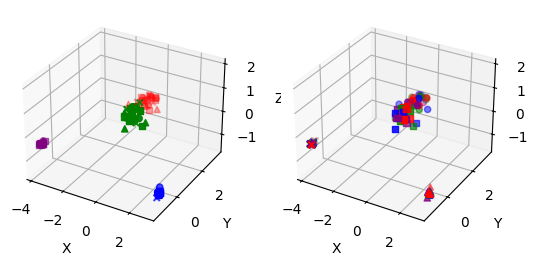

In [147]:
dims = 10
groups = 4
n_classes = 4
n_samples = 100
variance=(0.01, 0.2)


XX, YY = base_random_centroids(dims, n_classes, n_samples, variance)
XX = expand_features_rbf(XX, 2)
PP = random_uniform_partition(XX, YY, groups)


# Example Usage:
PXX = pca_3d(XX)

fig = plt.figure()
plot_3d_with_mapping(fig, PXX, YY, PP, pos=121)
plot_3d_with_mapping(fig, PXX, PP, YY, pos=122)



plt.show()

In [150]:
 import torch
 import torch.nn as nn
 import torch.optim as optim
 

 class SimpleNN(nn.Module):
  def __init__(self, input_dim, num_classes):
      super(SimpleNN, self).__init__()
      self.fc1 = nn.Linear(input_dim, 64)
      self.relu = nn.ReLU()
      self.fc2 = nn.Linear(64, num_classes)
     

  def forward(self, x):
      x = self.fc1(x)
      x = self.relu(x)
      x = self.fc2(x)
      return x
     

 def train_nn(XX, YY, num_classes, learning_rate=0.001, epochs=100):
  """
  Trains a simple neural network on the given data.
 

  Args:
  XX: Feature data (numpy array).
  YY: Class labels (numpy array).
  num_classes: Number of classes.
  learning_rate: Learning rate for the optimizer.
  epochs: Number of training epochs.
 

  Returns:
  model: Trained PyTorch model.
  """
  X_train = torch.tensor(XX, dtype=torch.float32)
  y_train = torch.tensor(YY, dtype=torch.long)
 

  input_dim = XX.shape[1]
  model = SimpleNN(input_dim, num_classes)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
 

  for epoch in range(epochs):
      optimizer.zero_grad()
      outputs = model(X_train)
      loss = criterion(outputs, y_train)
      loss.backward()
      optimizer.step()
 

  return model


ModuleNotFoundError: No module named 'torch'